In [23]:
import pandas as pd
import numpy as np

df = pd.read_csv('drive/MyDrive/complaints_processed.csv')

df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [24]:
df.isnull().sum()

Unnamed: 0     0
product        0
narrative     10
dtype: int64

In [25]:
df['product'].value_counts()

credit_reporting       91179
debt_collection        23150
mortgages_and_loans    18990
credit_card            15566
retail_banking         13536
Name: product, dtype: int64

In [26]:
df_clean = df.copy()
df_clean = df_clean.dropna()

In [27]:
df_clean.isnull().sum()

Unnamed: 0    0
product       0
narrative     0
dtype: int64

In [28]:
df_clean = df_clean.drop(columns ='Unnamed: 0')

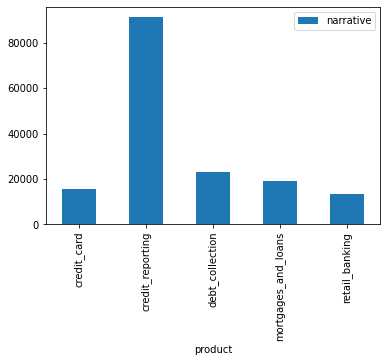

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

df_clean.groupby('product').count().plot(kind = 'bar')
plt.show()

In [30]:
df_clean.head()

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


In [31]:
df_dum = df_clean.copy()

df_dum = pd.get_dummies(df_dum, columns = ['product'])
df_dum.head()

,narrative,product_credit_card,product_credit_reporting,product_debt_collection,product_mortgages_and_loans,product_retail_banking
0,purchase order day shipping amount receive pro...,1,0,0,0,0
1,forwarded message date tue subject please inve...,1,0,0,0,0
2,forwarded message cc sent friday pdt subject f...,0,0,0,0,1
3,payment history missing credit report speciali...,0,1,0,0,0
4,payment history missing credit report made mis...,0,1,0,0,0


In [32]:
df_dum['narrative'].values

array(['purchase order day shipping amount receive product week sent followup email exact verbiage paid two day shipping received order company responded im sorry inform due unusually high order volume order shipped several week stock since early due high demand although continuing take order guaranteeing receive order place due time mask order exact shipping date right however guarantee ship soon soon delivers product u getting small shipment shipping first come first served basis appreciate patience fulfill order quickly recommend keeping order lose place line cancel distributor stock moment prefer cancel please note ask via email cancel accordance cancellation policy agreed checkout electronic inventory online requested order canceled refund issued canceled order sent verification order canceled refunded item particulate respirator refunded subtotal shipping tax total usd visa ending refund called disputed amount stated nothing needed submitted address issue recharged item removing 

In [33]:
from sklearn.model_selection import train_test_split

df_split = df_dum.copy()

X = df_split['narrative'].values
y = df_split[['product_credit_card','product_credit_reporting'	,'product_debt_collection'	,'product_mortgages_and_loans','product_retail_banking']].values

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3)

In [34]:
import re

def clean_text(narrative):
 
    narrative = re.sub('[^a-zA-Z]', ' ', narrative)  

    narrative = narrative.lower()  

    # split to array(default delimiter is " ") 
    narrative = narrative.split()  
    
    narrative = [w for w in narrative if not w in set(stopwords.words('english'))] 

    narrative = ' '.join(narrative)    
            
    return narrative

In [35]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

narrative = df_split.narrative[5]
print(narrative)
clean_text(narrative)

payment history missing credit report made mistake put account forbearance without authorization knowledge matter fact automatic payment setup month monthly mortgage paid full noticed issue account marked forbearance credit report tried get new home loan another new bank contacted immediately asked fix error provide letter detail please see asks forbearance issue seemed fixed however credit report payment history missing new bank able approve new loan issue missing payment history contacted time since phone ask thing report payment history experian fix missing data issue provide letter show account never forbearance payment history past month however waiting week countless email phone call talk multiple supervisor able get either one thing without issue fixed new bank process new loan application therefore need help immediately get fixed


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'payment history missing credit report made mistake put account forbearance without authorization knowledge matter fact automatic payment setup month monthly mortgage paid full noticed issue account marked forbearance credit report tried get new home loan another new bank contacted immediately asked fix error provide letter detail please see asks forbearance issue seemed fixed however credit report payment history missing new bank able approve new loan issue missing payment history contacted time since phone ask thing report payment history experian fix missing data issue provide letter show account never forbearance payment history past month however waiting week countless email phone call talk multiple supervisor able get either one thing without issue fixed new bank process new loan application therefore need help immediately get fixed'

In [36]:
df_split['narrative'] = df_split['narrative'].apply(lambda x : clean_text(x))

In [37]:
# from collections import Counter

# def counter_word(narraive):
#   count = Counter()
#   for i in narrative.values:
#     for word in i.split():
#       count[word]+= 1
#   return count

In [38]:
# txt = df_split['narrative']

# counter = counter_word(txt)
# print(f"The len of unique words is: {len(counter)}")
# list(counter.items())[:10]

In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = 5000, oov_token = 'x')

tokenizer.fit_on_texts(X_train)
# tokenizer.fit_on_text(X_test)

seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)

pad_train = pad_sequences(seq_train)
pad_test = pad_sequences(seq_test)


In [40]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim = 5000, output_dim = 16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(5, activation = 'sigmoid')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [41]:
class myCallback(tf.keras.callbacks.Callback):
   def on_epoch_end(self, epoch, logs ={}):
     if(logs.get('accuracy') > 0.9):
       print("\nAkurasi telah mencapai > 90 %!")
       self.model.stop_training = True
callbacks = myCallback()


In [20]:
num_epochs = 30
history = model.fit(pad_train, y_train, epochs = num_epochs, validation_data= (pad_test, y_test), verbose = 2, callbacks = [callbacks])

Epoch 1/30
3553/3553 - 294s - loss: 0.6229 - accuracy: 0.7713 - val_loss: 0.4832 - val_accuracy: 0.8311 - 294s/epoch - 83ms/step
Epoch 2/30
3553/3553 - 288s - loss: 0.4376 - accuracy: 0.8539 - val_loss: 0.4151 - val_accuracy: 0.8666 - 288s/epoch - 81ms/step
Epoch 3/30
3553/3553 - 289s - loss: 0.3803 - accuracy: 0.8741 - val_loss: 0.4020 - val_accuracy: 0.8671 - 289s/epoch - 81ms/step
Epoch 4/30
3553/3553 - 290s - loss: 0.3596 - accuracy: 0.8794 - val_loss: 0.4299 - val_accuracy: 0.8663 - 290s/epoch - 82ms/step
Epoch 5/30
3553/3553 - 288s - loss: 0.3283 - accuracy: 0.8906 - val_loss: 0.3879 - val_accuracy: 0.8728 - 288s/epoch - 81ms/step
Epoch 6/30
3553/3553 - 286s - loss: 0.3097 - accuracy: 0.8953 - val_loss: 0.3981 - val_accuracy: 0.8709 - 286s/epoch - 81ms/step
Epoch 7/30

Akurasi telah mencapai > 90 %!
3553/3553 - 285s - loss: 0.2936 - accuracy: 0.9004 - val_loss: 0.3938 - val_accuracy: 0.8709 - 285s/epoch - 80ms/step


In [21]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.622858,0.771284,0.483153,0.831069
1,0.437610,0.853923,0.415086,0.866616
2,0.380312,0.874146,0.402013,0.867150
3,0.359583,0.879450,0.429876,0.866329
4,0.328319,0.890638,0.387925,0.872753


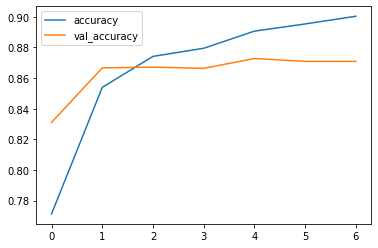

In [22]:
model_loss[['accuracy','val_accuracy']].plot()

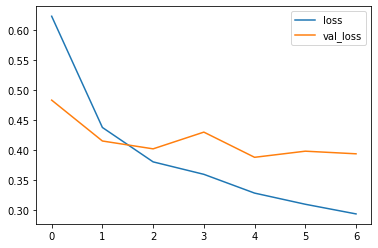

In [42]:
model_loss[['loss', 'val_loss']].plot()